In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score



from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv('../data/source.csv')
df.head(2)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,post_hint,url_overridden_by_dest,preview,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday,poll_data,is_gallery,gallery_data
0,ethereum,Curious after all that happened in 2022 what p...,t2_faby8iig,0.0,What percent ETH? BTC?,[],r/ethereum,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ethereum,&amp;#x200B;\n\n[Bitcasino](https://aff.partne...,t2_bcxd1l28,0.0,Bitcasino.io - The World’s first licensed Cryp...,[],r/ethereum,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df.subreddit.value_counts()

Bitcoin     164
ethereum    118
Name: subreddit, dtype: int64

In [40]:
df['subreddit'] = df.subreddit.apply(lambda x: 1 if x == 'Bitcoin' else 0)
df

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,post_hint,preview,crosspost_parent_list,url_overridden_by_dest,crosspost_parent,media_metadata,author_cakeday,poll_data,is_gallery,gallery_data
0,0,"\n\ni am attaching both his and my list, ple...",t2_mtdk9hgk,0,What is an active wallet? My blockchain group ...,[],r/ethereum,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1. I am trying to understand what happened whe...,t2_bkmsqnw5,0,Two questions on Ethereum forks,[],r/ethereum,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,# …The Truth About CBDCs… Ominous Design Revea...,t2_23gdthxz,0,…The Truth About CBDCs… Design Choices by ECB ...,[],r/ethereum,False,6,NaN,...,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,"{'ihzthl1x8naa1': {'status': 'valid', 'e': 'Im...",NaN,NaN,NaN,NaN
3,0,"Hey all, admins delete if inappropriate!\n\nRe...",t2_qcfl25r,0,"We are running a $210,000 Code4rena Public Aud...",[],r/ethereum,False,6,NaN,...,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,&amp;#x200B;\n\nhttps://preview.redd.it/729hhi...,t2_wkp2v,0,Layer2 Arbitrum Guide to the Ecosystem,[],r/ethereum,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'729hhip4hmaa1': {'status': 'valid', 'e': 'Im...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,1,I see a lot of usernames on Twitter with 13%er...,t2_6a02c1l6,0,13%er,[],r/Bitcoin,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,1,Is it not currently possible to hold lighting ...,t2_6djs3p1y,0,Lightning Node Wallet,[],r/Bitcoin,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,1,"tl;dr: I'm buying at least 14 copies of ""The L...",t2_108c14,0,"New year, new Bitcoin education project!",[],r/Bitcoin,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'pupmhvrif0aa1': {'status': 'valid', 'e': 'Im...",NaN,NaN,NaN,NaN
274,1,[deleted],NaN,0,"Crypto Incidents Involving Exit Scams, Hacks, ...",[],r/Bitcoin,False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.subreddit.value_counts()

1    154
0    122
Name: subreddit, dtype: int64

In [44]:
X1 = df.title
x2 = df.selftext
y = df.subreddit

In [45]:
y.value_counts(normalize=True)

1    0.557971
0    0.442029
Name: subreddit, dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [54]:
cvec = CountVectorizer()


In [91]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [93]:
pipe = {
    'tvec__max_features': [i for i in range (1000, 6001, 1000)],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3, 5],
    'cvec__max_df': [i*.1 for i in range(50, 101, 5)],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3)]
}

In [94]:
gs = GridSearchCV(pipe_tvec, 
                  param_grid = pipe_tvec_params, 
                  cv = 5) 

In [95]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [1000, 2000, 3000, 4000, 5000,
                                                6000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english']})

In [96]:
gs.best_score_

0.7168168168168167

In [97]:
gs.best_params_

{'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [98]:
gs.score(X_test, y_test)

0.75

In [99]:
preds = gs.predict(X_test)

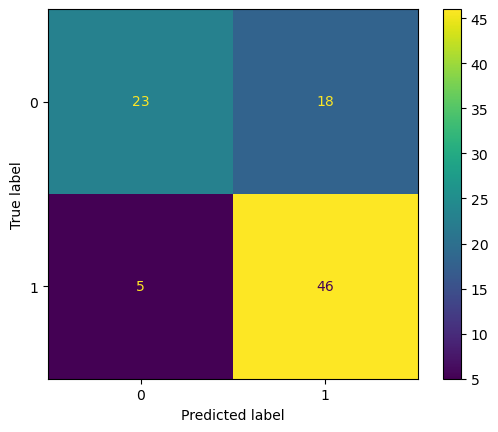

In [100]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = gs.classes_)

disp.plot();

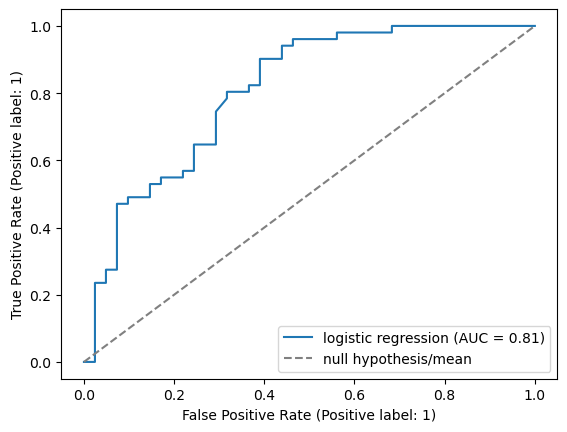

In [101]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(gs, X_test, y_test, ax=ax, name='logistic regression')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();